In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
import numpy as np
import os
import gzip

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split
# 注意housing本身的转变 以及train_test_split参数设置
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
# 函数式API（功能API）
# 输入层
input = keras.layers.Input(shape=x_train.shape[1:])

# hidden1 像函数一样调用input  复合函数 f(x) = h(g(x))
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)


# wide和deep 拼接
# 假设wide模型和deep模型输入是一样的  
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

# 固化模型
model = keras.models.Model(inputs=[input], outputs=[output])
model.compile(loss='mean_squared_error', optimize='adam')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [23]:
def draw_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid()
    plt.ylim(0, 1)
    plt.show()

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 111us/sample - loss: 1.1981 - val_loss: 0.5546
Epoch 2/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4756 - val_loss: 0.4510
Epoch 3/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4121 - val_loss: 0.4175
Epoch 4/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.3754 - val_loss: 0.3829
Epoch 5/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.3650 - val_loss: 0.3681
Epoch 6/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3517 - val_loss: 0.3543
Epoch 7/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3480 - val_loss: 0.3508
Epoch 8/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3381 - val_loss: 0.3386
Epoch 9/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3312 - val_

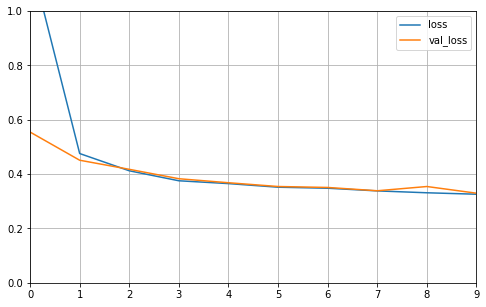

In [24]:
history = model.fit(x_train_scaled, y_train,
                   validation_data = [x_valid_scaled, y_valid],
                   epochs=10, callbacks=callbacks)
draw_learning_curve(history)

In [ ]:
model.evaluate(x_test_scaled, y_test)

子类API
继承keras.models.Model

In [5]:
class WideDeepModel(keras.models.Model):
    # 重载父类初始化函数
    def __init__(self):
        # python3 super()中间可以省略子类名和self
        super().__init__()
        '''定义模型层次''' '''动态添加属性'''
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        
    # 重载call函数
    def call(self, input):
        '''完成模型的正向运算'''
        '''感觉和函数式的差不多只是分开来写'''
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output


# 创建对象
# 1、直接生成 summary显示细节
model_subclass = WideDeepModel()

# 2、用sequential 将实例放入列表传给Sequential  summary将WideDeepModel作为一个层次整体
# model_subclass = keras.models.Sequential([WideDeepModel()])
# 指定input_shape
model_subclass.build(input_shape=(None, 8))

model_subclass.summary()

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  270       
_________________________________________________________________
dense_1 (Dense)              multiple                  930       
_________________________________________________________________
dense_2 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_subclass.compile(loss='mean_squared_error', optimize='adam')
history = model_subclass.fit(x_train_scaled, y_train, validation_data=[x_valid_scaled, y_valid], epochs=10)